## 1.6 Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.





## Submit the results

Submit your results here: https://forms.gle/V8q5rv7QRoZ13Sft6

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline

The deadline for submitting is 24 May 2022 (Tuesday) 23:00 CET. After that, the form will be closed.


## Solution

* [Video](https://www.youtube.com/watch?v=feH1PMLyu-Q&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=9)
* [Notebook](homework.ipynb)


In [142]:
import pandas as pd

pd.options.display.float_format = '{:,.4f}'.format

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* **1154112**
* 1254112
* 1354112

In [143]:
df_jan = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0000,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0000,None,B00037


In [144]:
df_jan.shape

(1154112, 7)

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the average trip duration in January?

* 15.16
* **19.16**
* 24.16
* 29.16

In [145]:
df_jan.head()
df_jan['duration'] = df_jan.dropOff_datetime - df_jan.pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)
df_jan['duration'].mean()

19.167224093791006

## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? (**44286**)

In [146]:
df_jan['duration'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count   1,154,112.0000
mean           19.1672
std           398.6922
min             0.0167
1%              0.4167
5%              3.0167
50%            13.4000
95%            47.2500
99%            90.3000
max       423,371.0500
Name: duration, dtype: float64

In [147]:
df_jan = df_jan[(df_jan['duration'] >= 1) & (df_jan['duration'] <= 60)]
df_jan.shape

(1109826, 8)

In [148]:
1154112 - 1109826

44286

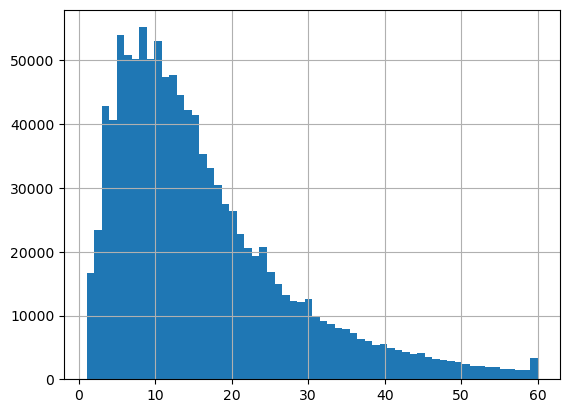

In [149]:
df_jan['duration'].hist(bins=60);

## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* **83%**

In [150]:
categorical = ['PUlocationID', 'DOlocationID']
df_jan[categorical] = df_jan[categorical].fillna(-1).astype('int')
df_jan.PUlocationID.value_counts(normalize=True)

-1     0.8353
 221   0.0075
 206   0.0061
 129   0.0048
 115   0.0037
        ...  
 111   0.0000
 27    0.0000
 34    0.0000
 2     0.0000
 110   0.0000
Name: PUlocationID, Length: 262, dtype: float64

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* **525**
* 725

In [151]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error


train_dicts = df_jan[categorical].astype('str').to_dict(orient='records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [152]:
X_train.shape

(1109826, 525)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 5.52
* **10.52**
* 15.52
* 20.52

In [153]:
target = 'duration'
y_train = df_jan[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519389001627

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

* 6.01
* **11.01**
* 16.01
* 21.01

In [154]:
df_feb = pd.read_parquet('../data/fhv_tripdata_2021-02.parquet')

df_feb['duration'] = df_feb.dropOff_datetime - df_feb.pickup_datetime
df_feb.duration = df_feb.duration.apply(lambda td: td.total_seconds() / 60)
df_feb = df_feb[(df_feb['duration'] >= 1) & (df_feb['duration'] <= 60)]
df_feb[categorical] = df_feb[categorical].fillna(-1).astype('int')

val_dicts = df_feb[categorical].astype('str').to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_feb[target].values
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)


11.014286537038522